# SuperStore Sales Forecasting 

<p aling='justify'> This analysis provide sales forecasting basing on super store dataset.</p>

Table of contents:
1. Notebook setup and modules import 
2. Data analysis and visualisation 
3. Data preprocessing 
4. Stationarity analysis 
5. Trend analysis
6. Differencing and trend decomposition 
7. AR, MA, ARIMA, SARIMAX
8. Best model selecetion and forecasts
9. Summary

### 1. Notebook setup and modules import

In [101]:
%pip install Config/requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'Config/requirements.txt'


In [102]:
%load_ext sql 

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [103]:
%sql mssql+pyodbc://PLLUKOR1@local

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [105]:
%sql use SuperStore;

 * mssql+pyodbc://PLLUKOR1@local
Done.


[]

### 2. Data Analysis and Visualisation 

<p aling='justify'>To perform data preprocessing and time series forecasting properly, sufficient amount of sample is required. During the differencing process some cases are lost, so it is important to have as many data samples as possible with high flexibility according to generealization. SuperSotre dataset includes sales data for range of 4 years. Chosing proper basis is a key factor for time series forecasting and it is first step to do before kicking-off forecasting task. <p> 

In [106]:
query = '''
SELECT YEAR(OderDate) as 'Year'
       ,SUM(Sales)      AS TotalSales
FROM Orders 
GROUP BY  YEAR(OderDate)
ORDER BY Year;
'''

annualBasis = %sql $query
annualBasis = pd.DataFrame(annualBasis)
annualBasis.head()

 * mssql+pyodbc://PLLUKOR1@local
Done.


,Year,TotalSales
0,2014,480113.28
1,2015,469726.96
2,2016,607472.25
3,2017,732242.43


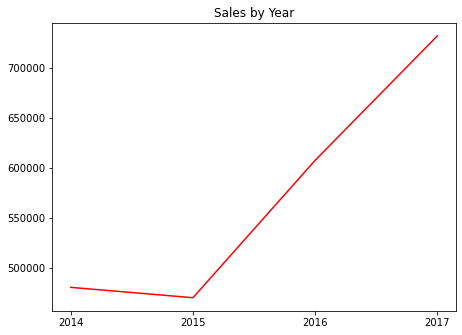

In [107]:
fig = plt.figure(figsize=(7,8))
ax = fig.add_axes((.1, .4, .8, .5))
ax.plot(annualBasis['Year'], annualBasis['TotalSales'], color='red')
ax.set_title('Sales by Year')
ax.set_xticks(annualBasis['Year'])
plt.show()

In [108]:
query = '''
SELECT YEAR(OderDate) as 'Year'
       ,Month(OderDate) as 'Month'
       ,SUM(Sales)      AS TotalSales
FROM Orders 
GROUP BY  YEAR(OderDate), Month(OderDate)
ORDER BY Year,Month;
'''

monthlyBasis = %sql $query
monthlyBasis = pd.DataFrame(monthlyBasis)
monthlyBasis.head()

 * mssql+pyodbc://PLLUKOR1@local
Done.


,Year,Month,TotalSales
0,2014,1,28953.71
1,2014,2,12743.12
2,2014,3,54801.96
3,2014,4,24592.89
4,2014,5,29639.84


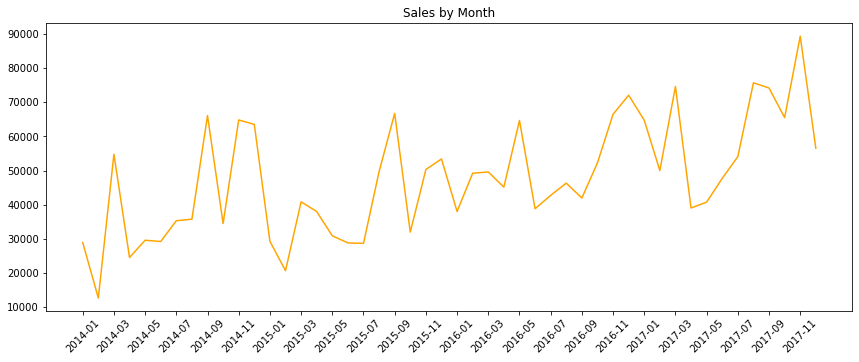

In [109]:
monthlyBasis['Month'] = ['0'+str(x) if len(str(x)) == 1 else str(x) for x in monthlyBasis['Month']]
monthlyBasis['Date'] = monthlyBasis['Year'].astype(str) + '-' + monthlyBasis['Month']

fig = plt.figure(figsize=(14,8))
ax = fig.add_axes((.1, .4, .8, .5))
ax.plot(monthlyBasis['Date'], monthlyBasis['TotalSales'], color='orange')
ax.set_title('Sales by Month')
ax.set_xticks(monthlyBasis['Date'][::2])
plt.xticks(rotation=45)
plt.show()

In [110]:
query = '''
SELECT YEAR(OderDate) as 'Year'
       ,DATEPART(week, OderDate) as 'Week'
       ,SUM(Sales)      AS TotalSales
FROM Orders 
GROUP BY  YEAR(OderDate), DATEPART(week, OderDate)
ORDER BY Year,Week;
'''

weeklyBasis = %sql $query
weeklyBasis = pd.DataFrame(weeklyBasis)
weeklyBasis.head()

 * mssql+pyodbc://PLLUKOR1@local
Done.


,Year,Week,TotalSales
0,2014,1,2791.94
1,2014,2,11224.09
2,2014,3,9754.93
3,2014,4,3123.73
4,2014,5,2059.02


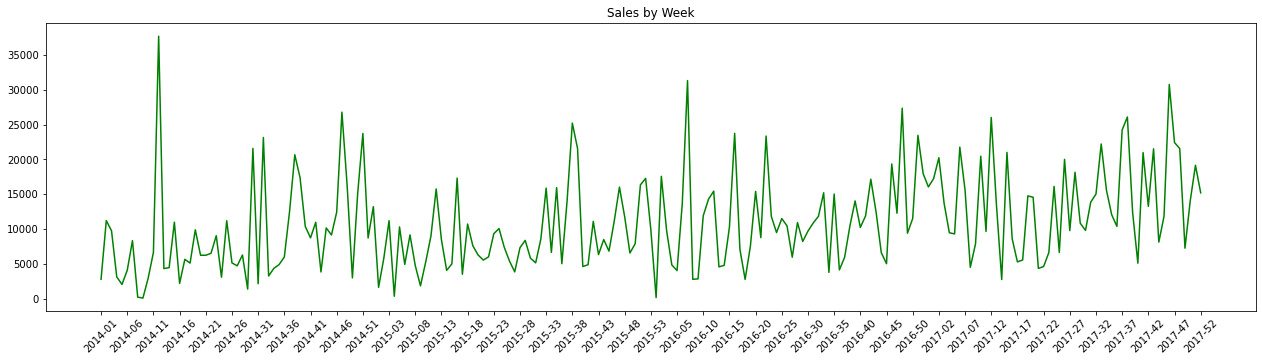

In [111]:
weeklyBasis['Week'] = ['0'+str(x) if len(str(x)) == 1 else str(x) for x in weeklyBasis['Week']]
weeklyBasis['Date'] = weeklyBasis['Year'].astype(str) + '-' + weeklyBasis['Week']

fig = plt.figure(figsize=(21,8))
ax = fig.add_axes((.1, .4, .8, .5))
ax.plot(weeklyBasis['Date'], weeklyBasis['TotalSales'], color='green')
ax.set_title('Sales by Week')
ax.set_xticks(weeklyBasis['Date'][::5])
plt.xticks(rotation=45)
plt.show()

<p align='justify'>Charts indicates significant upward trend, sales has grown up across the time. Chart with montly basis idicates significant seasonality, sales increases rapidly in fourth quarter every year and then decreases slightly at the begining of the another year. Chart which bases on weekly periods tends to have high variance which is diversiffied across particular periods. Green chart also reduces meaning of trend. </p>

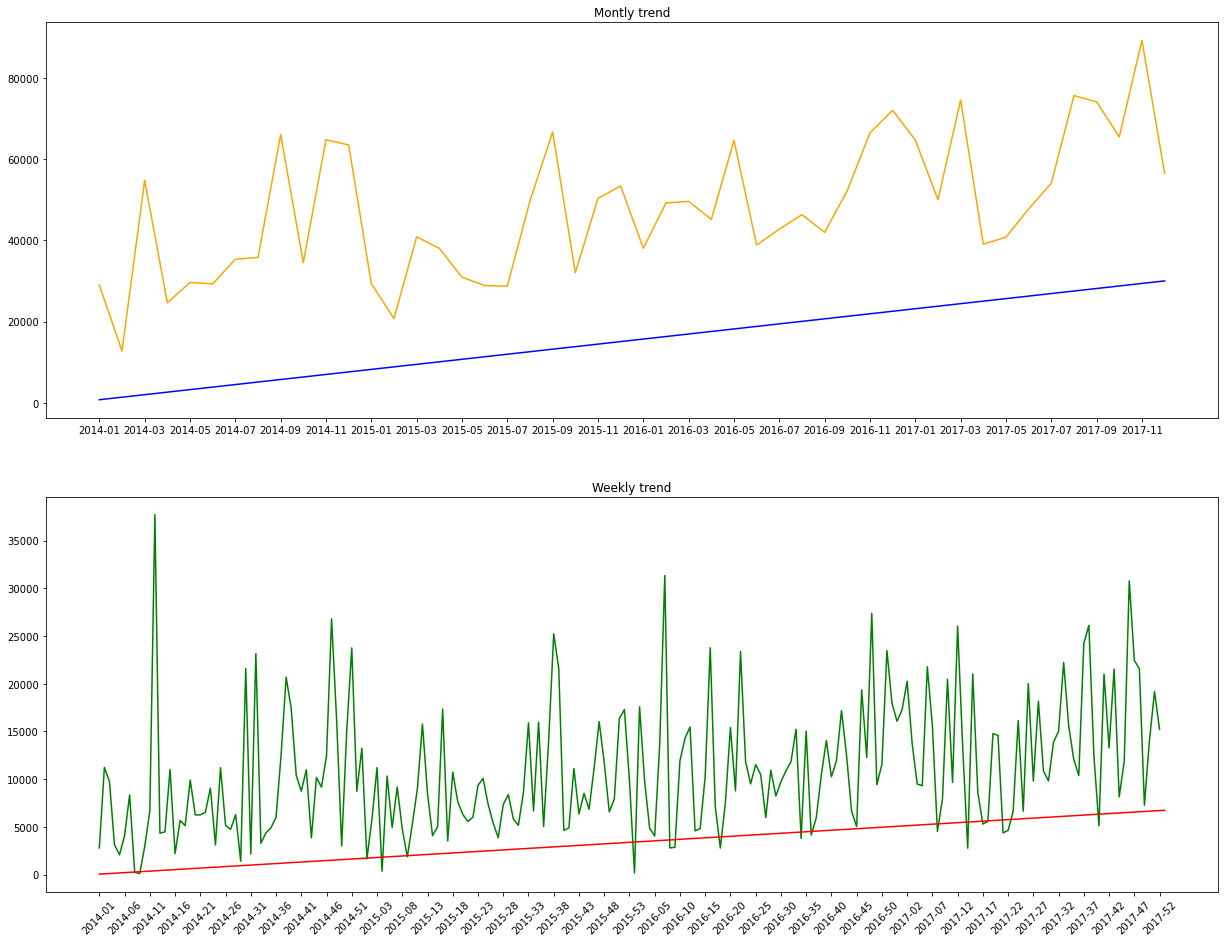

In [112]:
fig, axes = plt.subplots(2, 1, figsize=(21, 16))

weeklyTrend = np.polyfit(np.arange(1, len(weeklyBasis['Date'])+1), weeklyBasis['TotalSales'].astype(np.float64),1)
monthlyTrend = np.polyfit(np.arange(1, len(monthlyBasis['Date'])+1), monthlyBasis['TotalSales'].astype(np.float64),1)



axes[0].plot(monthlyBasis['Date'], monthlyBasis['TotalSales'], color='orange')
axes[0].plot(['2014-01', '2017-12'],monthlyTrend, color='blue')
axes[0].set_title('Montly trend')
axes[0].set_xticks(monthlyBasis['Date'][::2])
plt.xticks(rotation=45)


axes[1].plot(weeklyBasis['Date'], weeklyBasis['TotalSales'], color='green')
axes[1].plot(['2014-01', '2017-56'], weeklyTrend, color='red')
axes[1].set_title('Weekly trend')
axes[1].set_xticks(weeklyBasis['Date'][::5])
plt.xticks(rotation=45)
plt.show()


Becouse of higher gradation, more samples and more information kept, weekly basis will be picked to perform forecast. 